In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

import pandas as pd
import glob
import padasip as pa

dB = lambda x: 10*np.log10(x) # convert mag. to dB

# %load_ext autoreload # auto reload files
# %autoreload 2

## OpenBCI Data Acquisition
Testing data streaming from OpenBCI Ganglion

In [2]:
import time

import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations

board_id = 1 # ganglion definition

def init_openbci():
    BoardShim.enable_dev_board_logger()
    
    params = BrainFlowInputParams()
    params.serial_port = '/dev/cu.usbmodem11'
    
    board = BoardShim(board_id, params)
    return board

def stream_data(board, t_sec):
    board.prepare_session()
    board.start_stream()
    time.sleep(t_sec)
    # data = board.get_current_board_data (256) # get latest 256 packages or less, doesnt remove them from internal buffer
    data = board.get_board_data()  # get all data and remove it from internal buffer
    board.stop_stream()
    board.release_session()
    
    return data
    
board = init_openbci()

In [93]:
sample_time = 15
try:
    print(f"starting data acquisition for {sample_time}s")
    data=stream_data(board, sample_time)
except KeyboardInterrupt:
    print("Received interrupt: stopping session")
    board.stop_stream()
    board.release_session()
print("done")

starting data acquisition for 15s
done


In [91]:
eeg_channels = BoardShim.get_eeg_channels(board_id)
df_raw = pd.DataFrame(np.transpose(data))
df = df_raw[eeg_channels].rename(columns=dict(zip(range(1,5), [f'chan{i}' for i in range(1,5)])))


df = df[300:] # TODO: investigate what's causing weirdness in first few readings

In [68]:
from datetime import datetime as dt
ssvepf0 = 10
fname = f'eeg_ssvep{ssvepf0}Hz_{dt.now().isoformat()[5:19]}_LED_Oz.npz'

# save_data_npz(fname, df.values, meta=dict(record_len_sec=sample_time, ssvep_f0=ssvepf0))

Fundamental SSVEP frequency expected at 7.5Hz
Fundamental SSVEP frequency expected at 7.5Hz


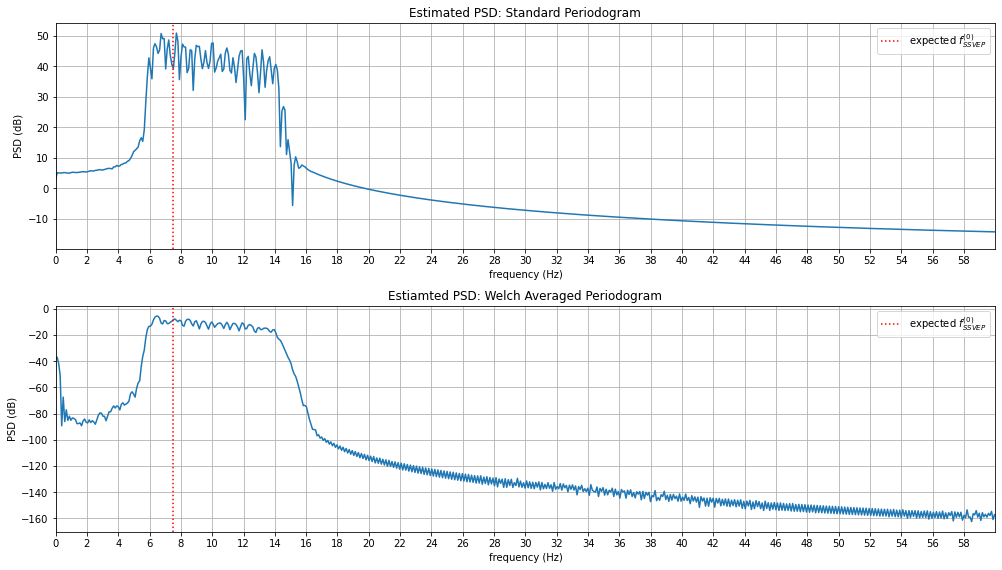

In [101]:
from eeg_lib.fbcca import cca_reference
from eeg_lib.filtering import iir_notch, butterworth_lowpass, iir_bandpass
from eeg_lib.freq_analysis import plot_periodogram

notch_50 = False
lowpass_25 = False
bandpass = True

ssvep_f0 = 7.5

def standardise(X):
    axis = np.argmax(X.shape)
    return (X-np.mean(X, axis=axis))/np.std(X, axis=axis)

Xraw = df.values
if notch_50:
    Xraw = np.array([iir_notch(Xraw[:, j], 50, 200) for j in range(Xraw.shape[1])]).T
    
if lowpass_25:
    Xraw = np.array([butterworth_lowpass(Xraw[:, j], 25, 200, order=2) for j in range(Xraw.shape[1])]).T
    
if bandpass:
    Xraw = np.array([iir_bandpass(Xraw[:, j], 5, 17, 200, order=8) for j in range(Xraw.shape[1])]).T

X = standardise(Xraw) #[:, -2:] # only choose last two channels: Oz, O1
plot_periodogram(X[:, 0], 200, ssvep_f0=ssvep_f0, N=2048, figsize=(14, 8))

In [102]:
from sklearn.cross_decomposition import CCA

candidate_freqs = [10, 7.5] #{str(f):f for f in [10, 13]}
rho_vals = []

for f in candidate_freqs:
    Yraw = cca_reference([f], 200, len(df), num_harms=2).reshape(-1, len(df)).T
    Y = standardise(Yraw)
#     wgn = np.random.normal(0, 1, Y.shape)

    cca = CCA(n_components=1)
    cca.fit(X, Y)
    Xc, Yc = cca.transform(X, Y) # canonical variable matrices. Xc = X^T.W_x

    rho = np.corrcoef(Xc[:400, 0], Yc[:400, 0])[0][-1]
    rho_vals.append(rho)
    print(f"candidate freq: {f}Hz, rho: {round(rho, 4)}")

candidate freq: 10Hz, rho: 0.0062
candidate freq: 7.5Hz, rho: 0.1527


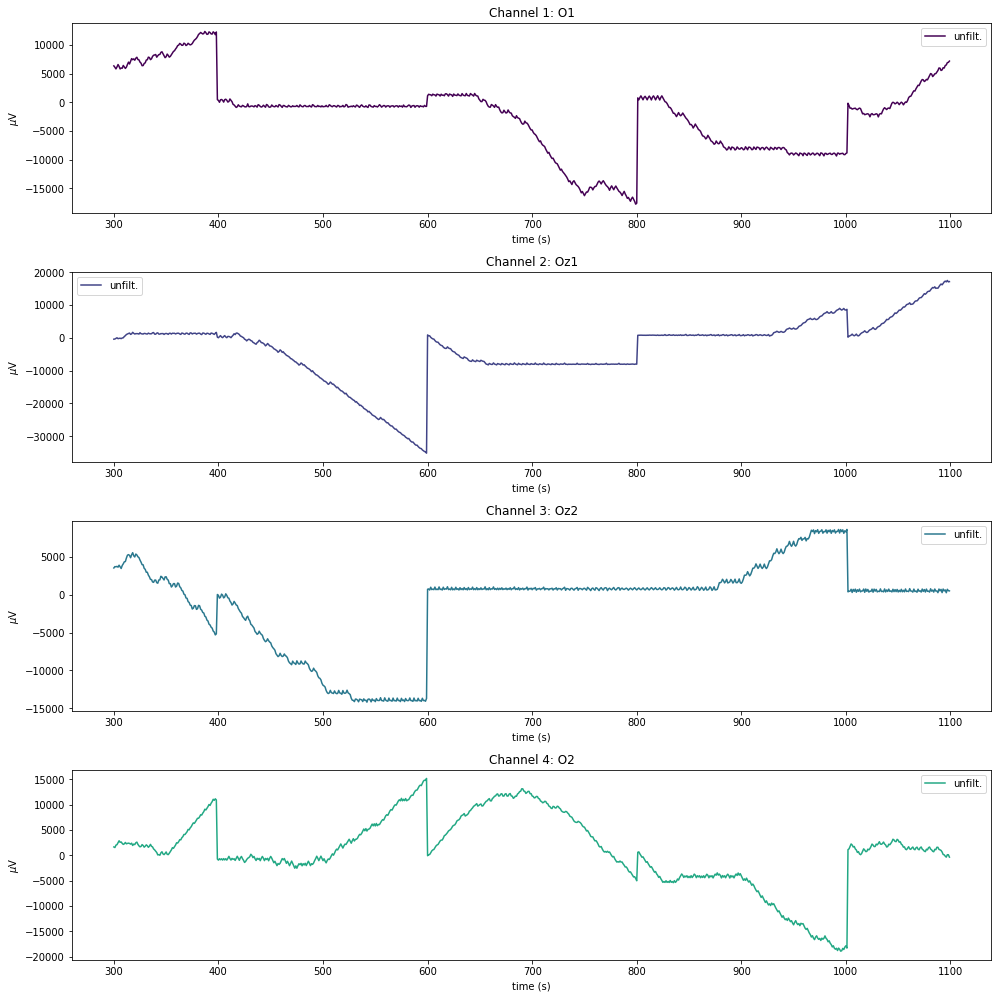

In [55]:
from matplotlib.cm import get_cmap
from eeg_lib.utils import save_data_npz, load_df

cm = get_cmap('viridis')

df_filt_bp = df.copy()
df_filt_lp = df.copy()
filter_ord = 4
centre_freq = 15
bandwidth = 15

for chann in df.columns: # filtering
    # centre freq, bandwidth
    DataFilter.perform_bandpass(df_filt_bp[chann].values, BoardShim.get_sampling_rate(board_id), centre_freq, bandwidth, filter_ord,
                                        FilterTypes.BESSEL.value, 0.05)
    DataFilter.perform_lowpass(df_filt_lp[chann].values, BoardShim.get_sampling_rate(board_id), 20, filter_ord+3,
                                        FilterTypes.BESSEL.value, 0.001)

df_filt = df_filt_bp    

fig, axes = plt.subplots(4,1,figsize=(14,14))
chan_labels = ['O1', 'Oz1', 'Oz2', 'O2']

for i, col in enumerate(df.columns):
    t_ax = np.linspace(0, sample_time, num=len(df))
    axes[i].plot(df[col][:800], label='unfilt.', c=cm(i*0.2))
#     axes[i].plot(df_filt[col][:800], label='filt', ls='-.', c=cm(i*0.2+0.1))
    axes[i].set_title(f'Channel {i+1}: {chan_labels[i]}')
    axes[i].set_xlabel('time (s)')
    axes[i].set_ylabel('$\mu$V')
    axes[i].legend()

plt.tight_layout(pad=1.2)

Target SSVEP frequencies (Hz) at: {'F1': 10, 'F2': 15}. Running experiment with SSVEP_f0 = 10Hz
Window start times in seconds: [2.56, 3.84, 5.12, 6.4, 7.68, 8.96]


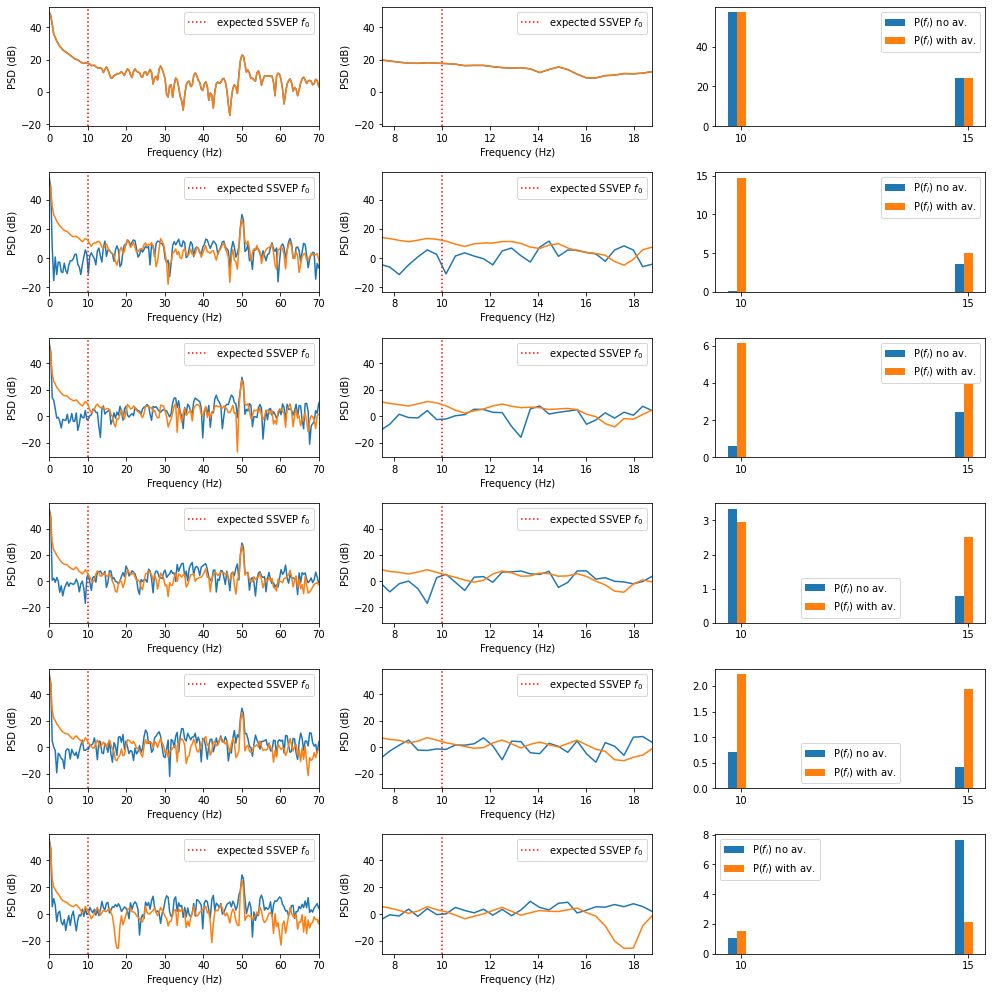

In [64]:
from eeg_lib.freq_analysis import plot_stft_spectra

fs = 200
win_len = 512 # window size in num samples

freq_map = {'F1': 10, 'F2':15}
f_ssvep = np.array(list(freq_map.values()))

ssvep_f0 = 10

target_df = df
x = target_df['chan4']

f, t, Sxx = signal.stft(x, fs, nperseg=win_len, noverlap=win_len//2, window='hann')

f_ssvep = np.array(list(freq_map.values()))
n_plots = 6 # number of windows to consider. Takes first n windows from Sxx matrix
# plot
plot_stft_spectra(Sxx[:, :n_plots], f, ssvep_f0=ssvep_f0, f_ssvep=f_ssvep, figsize=(14,14))

print(f"Target SSVEP frequencies (Hz) at: {freq_map}. Running experiment with SSVEP_f0 = {ssvep_f0}Hz")
win_times = [(1/fs)*win_len*(1+i/2) for i in range(n_plots)]
print(F"Window start times in seconds: {win_times}")